Here I'll be doing the exercises recommended in the description of the second video. I.e, a reality check to see if I know what I'm doing.

Exercises:
E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
E06: meta-exercise! Think of a fun/interesting exercise and complete it.

## E01
Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [1]:
import torch
words = open('names.txt', 'r').read().splitlines()
chars = list(sorted((set(''.join(words))))) # list a-z
string_to_int =  {s:i+1 for i,s in enumerate(chars)} # Btw, this is so weird lmao (in terms of being efficient) but I guess this is for generalisation, in case it wasn't just letters of the alphabet but something more.
string_to_int['.'] = 0
int_to_string =  {i:s for s, i in string_to_int.items()}

Actually, okay wait maybe we'll do a trigram model classic too hang on.

So, what were we actually doing before?
Basically, we make a matrix, and we count took the cur and next character, and added +1 count to that instancce on the matrix. Okay.

I had a bit of time to think about this and X out methods like a 27x27, 27x27 table etc. And I've come to the inclusion: I need a 27x27, 27 size table. Because, we are considering the last 2 characters as our inputs! And we are predicting/creating the counts of how many times, given the past 2 characters, did character *j* (column) show up! Okay!

So your rows would be '.., .a, .b, a., aa, ab, ac, ...'. Obviously there's gonna be a redundancy for every X. column but I don't wanna think about that right now.

Remember how our trigram idea works! *Given the past 2 characters, what is the current character?*. That is the fundamental idea here.

## Just fleshing out ideas for classic trigram
```
N = torch.zeros((27*27, 27), dtype=torch.int32)
    
for w in words[:1]:
    chs =  ['.'] + list(w) + ['.']

    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # zip is so cool
        print(ch1, ch2, ch3) # So ch1, ch2 are actually inputs to the system.
        # Shit. I need a 0-768 string to int thingy. Um. Okay. Anyways, let's imagine we have that.
        # Although, if we have that string to int thingy then we're set.
        # Basically the idea is ch1+ch2 = .., like 'aj' or something. 
        # Then we
        N[ixPog, ix2] += 1 
        ...
```
Unless!

In [38]:
# Fuck the visualisations! king hit this shit!
N = torch.zeros((27, 27, 27), dtype=torch.int32)
    
for w in words:
    chs =  ['.'] + list(w) + ['.']

    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # zip is so cool
        ix1 = string_to_int[ch1]
        ix2 = string_to_int[ch2]
        ix3 = string_to_int[ch3]
        # Shove it in that 3D matrix!
        N[ix1, ix2, ix3] += 1
N.shape  # So basically, the 2D array 'in front' is the input section, and then 
 # along the third dimension is the counts values. 

torch.Size([27, 27, 27])

In [73]:
def inspect_N(ch1, ch2, ch3):
    # Returns how many times a given ch3 appears after a ch1, ch2 sequence.
    ix1 = string_to_int[ch1]
    ix2 = string_to_int[ch2]
    ix3 = string_to_int[ch3]
    print(f'At position ({ix1}, {ix2}, {ix3})')
    return N[ix1, ix2, ix3].item()
inspect_N('.','a','b')

At position (0, 1, 2)


190

I lied, I love visuals. But, is this method scalable??? Like, am I just gonna add a new dimension for every new character that we have to consider?? That sounds wrong. I think I'm missing something
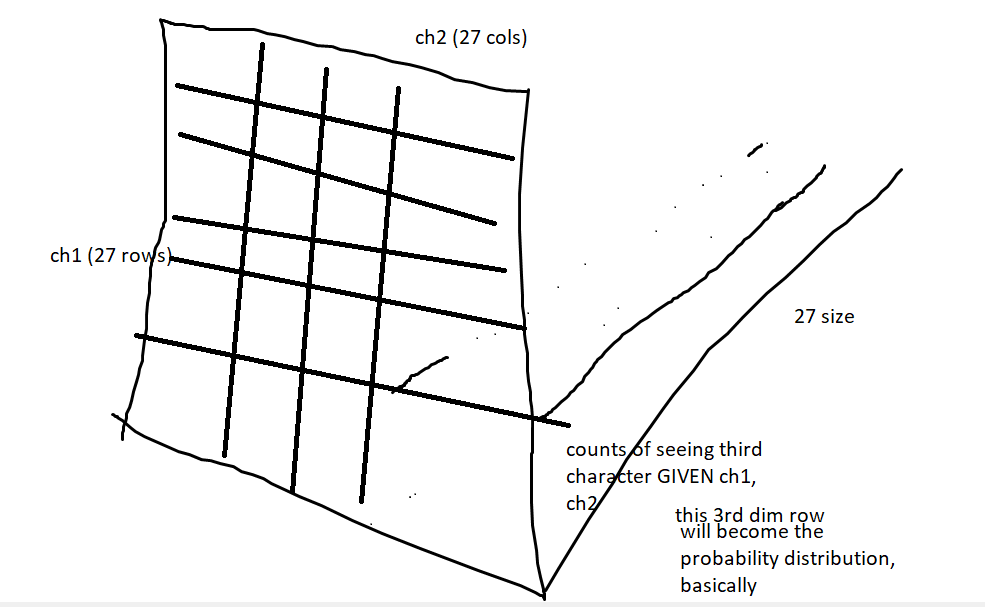

In [56]:
# Mini check:
p = N[0, 1].float() # how many characters had a '.' followed by 'a' before it.
p /= p.sum()
p.shape, p.sum() # Sanity check
# Test sampling this 
g = torch.Generator().manual_seed(2147483647) # keeps the same 'randomness' generated
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix, int_to_string[ix] # So given '.', 'a', it picked out 'r'. after.

(18, 'r')

In [86]:
# Now we P (probability dist.) matrix this mofo
P = (N+1).float() # We basically want to sum along the 3rd axis, so the sum of P[ix1, ix2] should always be 1
# Smoothing very important!! It sets out '.','.' sequence to equal distribution, so we can start our initial sampling.
P /= P.sum(2, keepdim=True)

assert P[0, 0].sum() == 1 # SANITY CHECK


In [87]:
P[0,0].sum()

tensor(1.)

In [89]:
# Okay, now we sample for real using our trigram model

g = torch.Generator().manual_seed(2147483647) # keeps the same 'randomness' generated

for i in range(10):
    # The idea is, given a start and a random character, then we get a prob dist of the 3rd character.
    # ANd we output it. And we set that 3rd character's index representation as our new second, and our second as our new first index.

    ix1, ix2 = 0, 0
    out = []
    while True:

        p = P[ix1, ix2] # This can only happen (sampling from '.','.' sequence because we smoothed with (N+1).float()!!!!!)
        # Or else, this prob dist would all be 'nan' (i.e None), and it'd give us an error. Our assert above even checks for this! Damn, asserts op!

        ix1 = ix2 # Move our characters along
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(int_to_string[ix2])

        if ix2 == 0:
            break
    print(''.join(out))

        

quia.
yu.
quinslyntien.
nolliahi.
ha.
quetony.
uri.
tackareibaidredelingh.
willah.
zulm.


So, it gives us a loss of 2.09 so it has actually improved compared to the bigram model.
#### okay, let's try to go our Neural Network route again

In [2]:
# Create training set of bigrams
def generate_training_set(words):
    """ Returns the xs, ys,"""
    xs, ys = [], [] # Bigram labels. given xs, label ys. Ofc, we want these in integers so we convert char -> int below
    for w in words:
        chs = ['.'] + list(w) + ['.'] # Adding special token
        # print(list(zip(chs, chs[1:], chs[2:]))) # DON'T UNPRINT THIS WITHOUT CAPPING OFF THE WORDS to like words[:3]
        
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # zip makes 'emma' -> '(e,m),(m,m),(m,a)'.  Ofc we have special tokens too so it different.
            ix1 = string_to_int[ch1]
            ix2 = string_to_int[ch2]
            ixOut = string_to_int[ch3]
            xs.append((ix1, ix2))
            ys.append(ixOut)

    xs = torch.tensor(xs) 
    ys = torch.tensor(ys) 

    return xs, ys
xs, ys = generate_training_set(words[:1])
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1]])

In [178]:
xs.shape, ys.shape # 4 examples, 2 characters for xs. And 4 labels (3rd character indexes)
# Now we want to one hot encode them.

(torch.Size([4, 2]), torch.Size([4]))

In [11]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
xenc = F.one_hot(xs, num_classes=27)
print(xenc)
# Okay, so when we look at the damn thing, we see that each 'section' (example) actually contains our
# first index, then the second one. E.g xenc[0] -> '.', 'e', xenc[1] -> 'e', 'm'
#  But they're in a different tensor. Let's put them in the same tensor!
xenc[1][1][string_to_int['m']] # See how we have to go into the second tensor of the 2nd training example? The second part should be combined, so we do that

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]])


tensor(1)

In [23]:
xenc_flattened = xenc.reshape(4,-1).float() # What the hell, -1 is magic! This basically flattens the inside lists together
xenc_flattened, xenc_flattened.shape

(tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0]]),
 torch.Size([4, 54]))

In [185]:
W = torch.randn((27*2, 27), generator=g) # Was (27,1) before for '1' neuron, but if you make it (27,27) it effectively evaluates all 27 neurons on all 5 inputs.

logits = xenc_flattened @ W
# logits.shape
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape
# loss = -probs[torch.arange(4), ys].log().mean() 
# loss

torch.Size([4, 27])

In [187]:
probs[0, 13], probs[1, 13], probs[2, 1], probs[3, 0]

(tensor(0.0343), tensor(0.0166), tensor(0.0068), tensor(0.0018))

In [181]:
W.grad = None
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [164]:
# okay, so for the real thing:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.'] # Adding special token
    # print(list(zip(chs, chs[1:], chs[2:]))) # DON'T UNPRINT THIS WITHOUT CAPPING OFF THE WORDS to like words[:3]
    
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # zip makes 'emma' -> '(e,m),(m,m),(m,a)'.  Ofc we have special tokens too so it different.
        ix1 = string_to_int[ch1]
        ix2 = string_to_int[ch2]
        ixOut = string_to_int[ch3]
        xs.append((ix1, ix2))
        ys.append(ixOut)
    

xs = torch.tensor(xs) 
ys = torch.tensor(ys) 
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

number of examples:  392226


In [167]:
# gradient descent - how many times are we doin it, chief?
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  xenc_flattened = xenc.view(len(xenc), -1).float() ### WE WERE MISSING THIS PART.


  logits = xenc @ W # predict log-counts -- logits, are the outputs of the NN layer, just before we softmax (normalise to get prob distr) it!
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character ## Exponentiating and normalising => softmax. Literally, lol.
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # this 0.01W^2.mean() bit is regularisation loss (smooths out the probability distribution! (by making weights have some incentive to be near 0; see below).
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50* W.grad

RuntimeError: mat1 and mat2 shapes cannot be multiplied (392226x27 and 54x27)

In [9]:
# # I'll go with a neural net route.

# for w in words[:1]:
#     chs = ['.'] + list(w) + ['.'] # Adding special token
#     print(list(zip(chs, chs[1:], chs[2:]))) # DON'T UNPRINT THIS WITHOUT CAPPING OFF THE WORDS to like words[:3]
    
#     # for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]) # Zip is so nice. This'll be a trigram now.
    

[('.', 'e', 'm'), ('e', 'm', 'm'), ('m', 'm', 'a'), ('m', 'a', '.')]


In [ ]:
# # Dataset manipulation
# import torch.nn.functional as F

# # Create training set of bigrams
# xs, ys = [], [] # Bigram labels. given xs, label ys. Ofc, we want these in integers so we convert char -> int below
# for w in words:
#     chs = ['.'] + list(w) + ['.'] # Adding special token
#     # print(list(zip(chs, chs[1:]))) # DON'T UNPRINT THIS WITHOUT CAPPING OFF THE WORDS to like words[:3]
    
#     for ch1, ch2 in zip(chs, chs[1:]): # zip makes 'emma' -> '(e,m),(m,m),(m,a)'.  Ofc we have special tokens too so it different.
#         ix1 = string_to_int[ch1]
#         ix2 = string_to_int[ch2]
#         xs.append(ix1)
#         ys.append(ix2)

# xs = torch.tensor(xs) # convert to tensor
# ys = torch.tensor(ys) 
# num = xs.nelement()
# print('number of examples: ', num)

# # generate weights
# g = torch.Generator().manual_seed(2147483647) 
# W = torch.randn((27,27), generator=g, requires_grad = True)

